In [133]:
%matplotlib inline

In [134]:
import numpy as np
import math
from random import shuffle
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model, datasets, preprocessing

In [135]:
with open('wine.data.txt') as f:
    content = [[float(x) for x in line.strip().split(',')] for line in f.readlines()]
shuffle(content)
trainingLabel = map(lambda x : x[0], content[:128])
trainingData = np.array(map(lambda x : x[1:]+[1], content[:128]))
testLabel = map(lambda x : x[0], content[128:])
testData = np.array(map(lambda x : x[1:]+[1], content[128:]))
# Nomalize
trainingData = trainingData/np.max(trainingData,0)
testData = testData/np.max(testData,0)

In [136]:
# Using sklearn to do standard logistic regression
logreg = linear_model.LogisticRegression(C = 1e5, solver = 'lbfgs', multi_class = 'multinomial')
logreg.fit(trainingData,trainingLabel)
Z = logreg.predict(testData)
errorRate = len(filter(lambda x: x[0] != x[1], zip(Z,testLabel)))*1.0/len(Z)
print errorRate

0.02


In [141]:
# Final optimal loss L*
def calculateLoss(coeff, X, y):
    '''
    X: training data np.array(num_Sample, num_feature)
    y: training label np.array(num_Sample)
    '''
    loss = 0
    for i in range(0,len(X)):
        loss -= np.dot(X[i], coeff[int(y[i])-1])
        loss += np.log(np.exp(np.dot(X[i], coeff[0]))+np.exp(np.dot(X[i], coeff[1]))+np.exp(np.dot(X[i], coeff[2])))
    return loss
predictProb = logreg.predict_proba(trainingData)
print metrics.log_loss(trainingLabel,predictProb)

0.147051185806


In [138]:
def plotUpdate2(batch, first, second, third, title , ylabel = 'L(w1)'):
    inOrder, = plt.plot([i*batch for i in range(0,len(first))], first)
    random, = plt.plot([i*batch for i in range(0,len(second))], second)
    oneByOne, = plt.plot([i*batch for i in range(0,len(third))], third)
    plt.xlabel('t')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend([inOrder, random, oneByOne], ['in-order-feature coordinate descent', 'random-feature coordinate descent', 'one-by-one-feature coordinate descent'])
    plt.grid(True)

In [139]:
def plotUpdate(batch, first, second, title , ylabel = 'L(w1)'):
    inOrder, = plt.plot([i*batch for i in range(0,len(second))], first)
    random, = plt.plot([i*batch for i in range(0,len(second))], second)
    plt.xlabel('t')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend([random, inOrder], ['random-feature coordinate descent', 'in-order-feature coordinate descent'])
    plt.grid(True)

In [148]:
class CoordinateDescent():
    def __init__(self):
        self.coef_ = np.zeros((3,14))
        self.numClass = 0
        self.numFeature = 0
        self.lossPath = []
        self.errorPath = []
        self.numIter = 1.5e5
        self.stepSize = 1e-2
        
    def calculateLoss(self, coeff, X, y):
        '''
        X: training data np.array(num_Sample, num_feature)
        y: training label np.array(num_Sample)
        '''
        loss = 0
        for i in range(0,len(X)):
            loss -= np.dot(X[i], coeff[int(y[i])-1])
            loss += np.log(np.exp(np.dot(X[i], coeff[0]))+np.exp(np.dot(X[i], coeff[1]))+np.exp(np.dot(X[i], coeff[2])))
        return loss
    
    def calculateDerivative(self, j, k, coeff, X, y):
        '''
        j: class number
        k: feature number
        '''
        derivative = 0
        for i in range(len(X)):        
            if int(y[i])-1 == j:
                derivative -= X[i][k]
            totalExp = np.exp(np.dot(X[i], coeff[0])) + np.exp(np.dot(X[i], coeff[1])) + np.exp(np.dot(X[i], coeff[2]))
            derivative += X[i][k] * np.exp(np.dot(X[i], coeff[j])) / totalExp
        return derivative
    
    def fit(self, trainingData, trainingLabel, testData, testLabel, randomize = False, warmStart = False, naive = False, batch = 100):
        '''
        randomize: randomly choose coordinate to do gradient descent
        warmStart: if True, don't reset coefficients all to zeros
        '''
        self.numClass = 3
        self.numFeature = len(trainingData[0])
        if naive:
            self.naiveCoordinateDescent(trainingData, trainingLabel, testData, testLabel, warmStart, batch)
        elif not randomize:
            self.inOrderCoordinateDescent(trainingData, trainingLabel, testData, testLabel, warmStart, batch)
        else:
            self.randomCoordinateDescent(trainingData, trainingLabel, testData, testLabel, warmStart, batch)
            
    def naiveCoordinateDescent(self, X, y, testData, testLabel, warmStart, batch):
        '''
        X: training data np.array(num_Sample, num_feature)
        y: training label np.array(num_Sample)
        '''
        if not warmStart:
            self.coef_ = np.zeros((3,14))
        numIter = 0
        while numIter <= self.numIter:
            for k in range(0, self.numFeature):
                for j in range(0, self.numClass):
                    # Update self.coef_[j][k] using gradient descent
                    self.coef_[j][k] -= self.stepSize * self.calculateDerivative(j, k, self.coef_, X, y)
                    numIter += 1
                    if numIter % batch == 0:
                        self.lossPath.append(self.calculateLoss(self.coef_, X, y))
                        self.errorPath.append(self.test(self.coef_, testData, testLabel))
                    if numIter % 1000 == 0:
                        print numIter,
                        
    def inOrderCoordinateDescent(self, X, y, testData, testLabel, warmStart, batch):
        '''
        X: training data np.array(num_Sample, num_feature)
        y: training label np.array(num_Sample)
        '''
        allSet = False
        if not warmStart:
            self.coef_ = np.zeros((3,14))
        numIter = 0
        j,k = 0,0
        lossChange = np.zeros(14)
        postLoss = self.calculateLoss(self.coef_, X, y)
        while numIter <= self.numIter:
            preLoss = postLoss
            # Update self.coef_[j][k] using gradient descent
            for j in range(0,3):
                self.coef_[j][k] -= self.stepSize * self.calculateDerivative(j, k, self.coef_, X, y)
                numIter += 1
                if numIter % batch == 0:
                    self.lossPath.append(self.calculateLoss(self.coef_, X, y))
                    self.errorPath.append(self.test(self.coef_, testData, testLabel))
                if numIter % 1000 == 0:
                    print numIter,
            postLoss = self.calculateLoss(self.coef_, X, y)
            lossChange[k] = preLoss - postLoss
            if not allSet:
                k += 1
                if k == 14:
                    allSet = True
            if allSet:
                k = np.argmax(lossChange)
                        
    def randomCoordinateDescent(self, X, y, testData, testLabel, warmStart, batch):
        '''
        X: training data np.array(num_Sample, num_feature)
        y: training label np.array(num_Sample)
        '''
        if not warmStart:
            self.coef_ = np.zeros((3,14))
        numIter = 0
        while numIter <= self.numIter:
            k = random.randint(0, self.numFeature-1)
            j = random.randint(0, self.numClass-1)
            # Update self.coef_[j][k] using gradient descent
            self.coef_[j][k] -= self.stepSize * self.calculateDerivative(j, k, self.coef_, X, y)
            numIter += 1
            if numIter % batch == 0:
                self.lossPath.append(self.calculateLoss(self.coef_, X, y))
                self.errorPath.append(self.test(self.coef_, testData, testLabel))
            if numIter % 1000 == 0:
                print numIter, 
                
    def test(self, coeff, testData, testLabel):
        error = 0
        for i in range(0,len(testData)):
            predictLabel = np.argmax(np.dot(coeff,testData[i]))+1
            if predictLabel != int(testLabel[i]):
                error += 1
        return error*1.0/len(testData)

In [149]:
# In-order-feature
coordinateDescent = CoordinateDescent()
coordinateDescent.fit(trainingData, trainingLabel, testData, testLabel, batch = 150)

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000


In [150]:
# Random-select-feature
coordinateDescentRandom = CoordinateDescent()
coordinateDescentRandom.fit(trainingData, trainingLabel, testData, testLabel, randomize = True, batch = 150)

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000


In [151]:
# # One-by-one feature
coordinateDescentNaive = CoordinateDescent()
coordinateDescentNaive.fit(trainingData, trainingLabel, testData, testLabel, naive = True, batch = 150)

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000


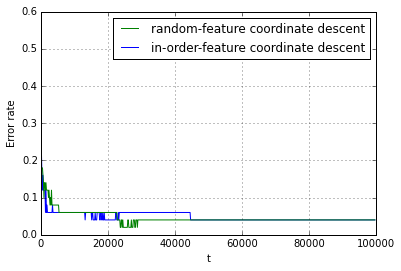

In [146]:
errorInOrder = coordinateDescent.errorPath
errorRan = coordinateDescentRandom.errorPath
errorNaive = coordinateDescentNaive.errorPath
plotUpdate(150, errorInOrder, errorRan, title = '', ylabel = 'Error rate')
# plt.savefig('error_step5e-4_2.jpeg')

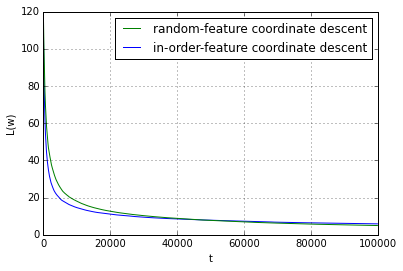

In [147]:
lossInOrder = coordinateDescent.lossPath
lossPathNaive = coordinateDescentNaive.lossPath
lossPathRan = coordinateDescentRandom.lossPath
plotUpdate(150, lossInOrder, lossPathRan,title = '', ylabel = 'L(w)')
# plt.savefig('Lw_step5e-4_2.jpeg')

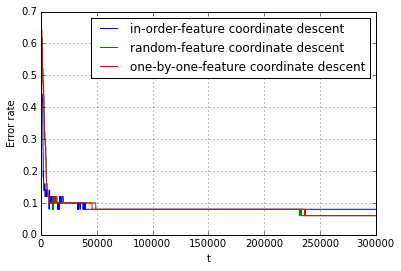

In [121]:
errorNaive = coordinateDescentNaive.errorPath
plotUpdate2(150, errorInOrder, errorRan, errorNaive, title = '', ylabel = 'Error rate')
plt.savefig('error_step5e-4_2_2.jpeg')

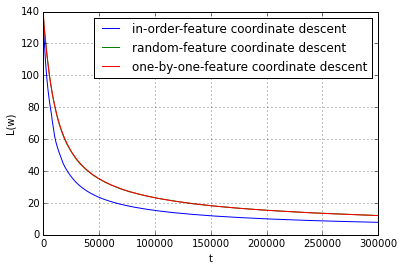

In [122]:
lossPathNaive = coordinateDescentNaive.lossPath
plotUpdate2(150, lossInOrder, lossPathRan, lossPathNaive, title = '', ylabel = 'L(w)')
plt.savefig('Lw_step5e-4_2_2.jpeg')